# Demograph generation from FIJI linescans. 
This is a basic code for generating a population demogrpah from individual linescans of cell profiles in ImageJ/FIJI. For this code to work properly, make sure your documents are properly organized.
- Have this code in the same folder/directory as your experiment. 
- Make sure there is a sub-folder in this experiment called "linescans." There, save all your CSV linescan exports from ImageJ.
- Every CSV should be named "Cell-xxxx.csv," where x's denote 0 padding. For example, linescan 1 would be "Cell-0001.csv." You can use a different number of 0s depending on how many manual linescans you generate. If you expect to make at least 1000 linescans, write "Cell-0001.csv," but between 999 and 100 linescans should be "Cell-001.csv."
- This will make a demograph and save it in the experiment folder. The specific code chunks below will explain what they do and what you can edit.

Code by Joshua W. McCausland in the Christine Jacobs-Wagner lab, 2025.

This first code chunk loads the required packages.
- If python says it is missing any package, you must install it. 
- If on Windows, go to "Anaconda Prompt" on the Anaconda Navigator homepage. This will open up a terminal with pyton access.
- If on Mac, open your terminal. 
- From there, type "pip install [package name]" This will install the package.
- For example, if you are missing the package tqdm, type "pip install tqdm" to install that package.

In [3]:
import numpy as np # array and numerical functions.
import pandas as pd # dataframe management
import glob,os,re # file organization, naming, and string management
from tqdm import tqdm # for displaying the progress.
from matplotlib import pyplot as plt # plotting

This code chunk below will load all of the linescans with the format "Cell-xxxx.csv" and store their information in a dataframe. Make sure the columns of your linescans have the title "Gray_Value."

In [13]:
# identify all csv files in the linescans folder.
linescans = glob.glob('linescans/*.csv')

# Create a blank dataframe that we will populate.
df = pd.DataFrame()

#Iterate through the linescans folder and archive the individual linescan data.
for linescan_file in tqdm(linescans):

    # Pull up the current linescan in the iteration.
    linescan_curr = pd.read_csv(linescan_file)

    # Find the linescan number in the filename.
    linescan_num = np.array(re.findall(r'\d+', linescan_file),dtype=int)[0]

    # Pull out the information for the current linescan.
    temp_df = pd.DataFrame({
        'filename': os.path.basename(linescan_file), # Store the filename.
        'sizes': linescan_curr.shape[0], # Store the size of the linescan.
        'linescan': [linescan_curr.Gray_Value.values] # Store the linescan itself.
    },index = [linescan_num])  

    # add the current linescan to the dataframe.
    df = pd.concat([df,temp_df],axis=0)

# Sort the dataframe from the shortest to the longest linescan.
df = df.sort_values('sizes').reset_index()

# Display the first five rows of the dataframe as an example.
display(df.head(5))

100%|███████████████████████████████████████| 1225/1225 [00:21<00:00, 57.80it/s]


,index,filename,sizes,linescan
0,59,Cell-0059.csv,137,"[138.05827, 138.05827, 147.19447, 188.81499, 2..."
1,418,Cell-0418.csv,164,"[1398.9775, 2283.1394, 2283.1394, 2655.581, 26..."
2,903,Cell-0903.csv,170,"[435.9821, 580.27875, 673.0409, 673.0409, 779...."
3,284,Cell-0284.csv,194,"[602.44916, 773.12616, 878.7834, 972.2493, 972..."
4,370,Cell-0370.csv,212,"[-11.613895, 109.8041, 138.31093, 130.92027, 1..."


This next code chunk will make the demograph array from all the linescans, lining the scans from shortest to longest and centering them.

In [14]:
# make an empty array of the shape of largest linescan by the number of linesecans.
demo = np.empty([df.sizes.max()+1,df.shape[0]])

# populate this empty array with NaN values. Important for displaying later.
demo[:] = np.nan

# Find the index of the dataframe that marks half of the longest linescan. 
# This is for centering linesecans.
half_width = np.ceil(df.sizes.max()/2).astype(int)

# Iterate through our linescan dataframe and populate the demograph array.
for index,row in df.iterrows():

    # pull up the current linescan.
    linescan = row.linescan

    # Find what indexes the bottom and top of the linescan will populate. 
    linescan_bottom = np.floor(len(linescan)/2).astype(int)
    linescan_top = np.ceil(len(linescan)/2).astype(int)

    # Use the bottom/top indexes of the linescan and orient them according to the halfway mark of the demograph array.
    # Normalize linescans by z-score. We are interested in WHERE signal is enriched in any one cell. Not comparing signal across cells.
    demo[half_width-linescan_bottom:half_width+linescan_top,index] = (linescan-linescan.mean())/linescan.std()
print('The demograph is prepared.')

The demograph is prepared.


Now plot the demograph. This will take the demograph array and plot it as an image.

/var/folders/90/_9d_lyss2d915_2hpwp_lst00000gn/T/ipykernel_81503/4255995388.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=2.5)


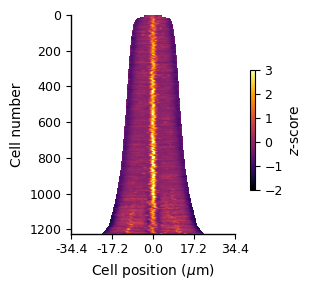

In [15]:
###############################################################################
# EDITABLE SECTION. Specify your experiment and plotting parameters here.A
# Put in the pixel size of your experiment here.
px_size = 0.065 # microns per pixel.

# the name by which your demograph will be saved.
savename = 'example_demograph'

# The size of the figure in inches, width x height.
figure_size = [3,3]

# The colormap of choice to display the demograph.
# Refer to matplotlb's colormap choices: https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = 'inferno'
###############################################################################

# Generate a figure of the specified size above.
fig,_ax = plt.subplots(figsize=figure_size,layout = 'constrained')

# plot the demograph. 
# NOTE. vmin and vmax are the min/max colors for z-score plotting. change these if you need. 
# vmin=-2 and vmax=3 work for my experiments, but may not in every case. 
cax = _ax.imshow(demo.T,cmap=color_map,vmin = -2,vmax=3, aspect="auto",interpolation = 'gaussian')

# Using the pixel size, generate xticks according to even spaces of cell length from the midcell position.
midpoint = np.ceil((df.sizes.max()+1)/2)
xtick_locations = [midpoint+midpoint,midpoint-midpoint, midpoint-midpoint/2, midpoint, midpoint+midpoint/2]
_ax.xaxis.set_ticks(xtick_locations,np.round((xtick_locations-midpoint)*px_size,1),fontsize=9)

# Plot x and y labels.
_ax.set_xlabel('Cell position ($\mu$m)')
_ax.set_ylabel('Cell number')

# Plot formatting.
_ax.spines[['top','right']].set_visible(False)
_ax.spines[['bottom','left']].set_linewidth(1)
_ax.tick_params(axis='both',labelsize=9)

# place a colorbar to depict the range of the z-score.
fig.tight_layout(h_pad=2.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.015, 0.4])
cbar = fig.colorbar(cax, cax=cbar_ax,label='$z$-score')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_yticks([-2,-1,0,1,2,3])

# save the figure in both PDF and PNG using your specified savename.
plt.savefig(f'{savename}.pdf',dpi=600,bbox_inches='tight')
plt.savefig(f'{savename}.png',dpi=600,bbox_inches='tight')